In [1]:
import os
import sys
import random

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

import fastai
from fastai.vision import *
import torch

from util import mask2rle, rle2mask


In [2]:
# const
data_path = '../../data/siim-pneumothorax'
path = Path(data_path)

data_split_path = 'unet_siim_5fold_256'

torch.cuda.set_device('cuda:0')

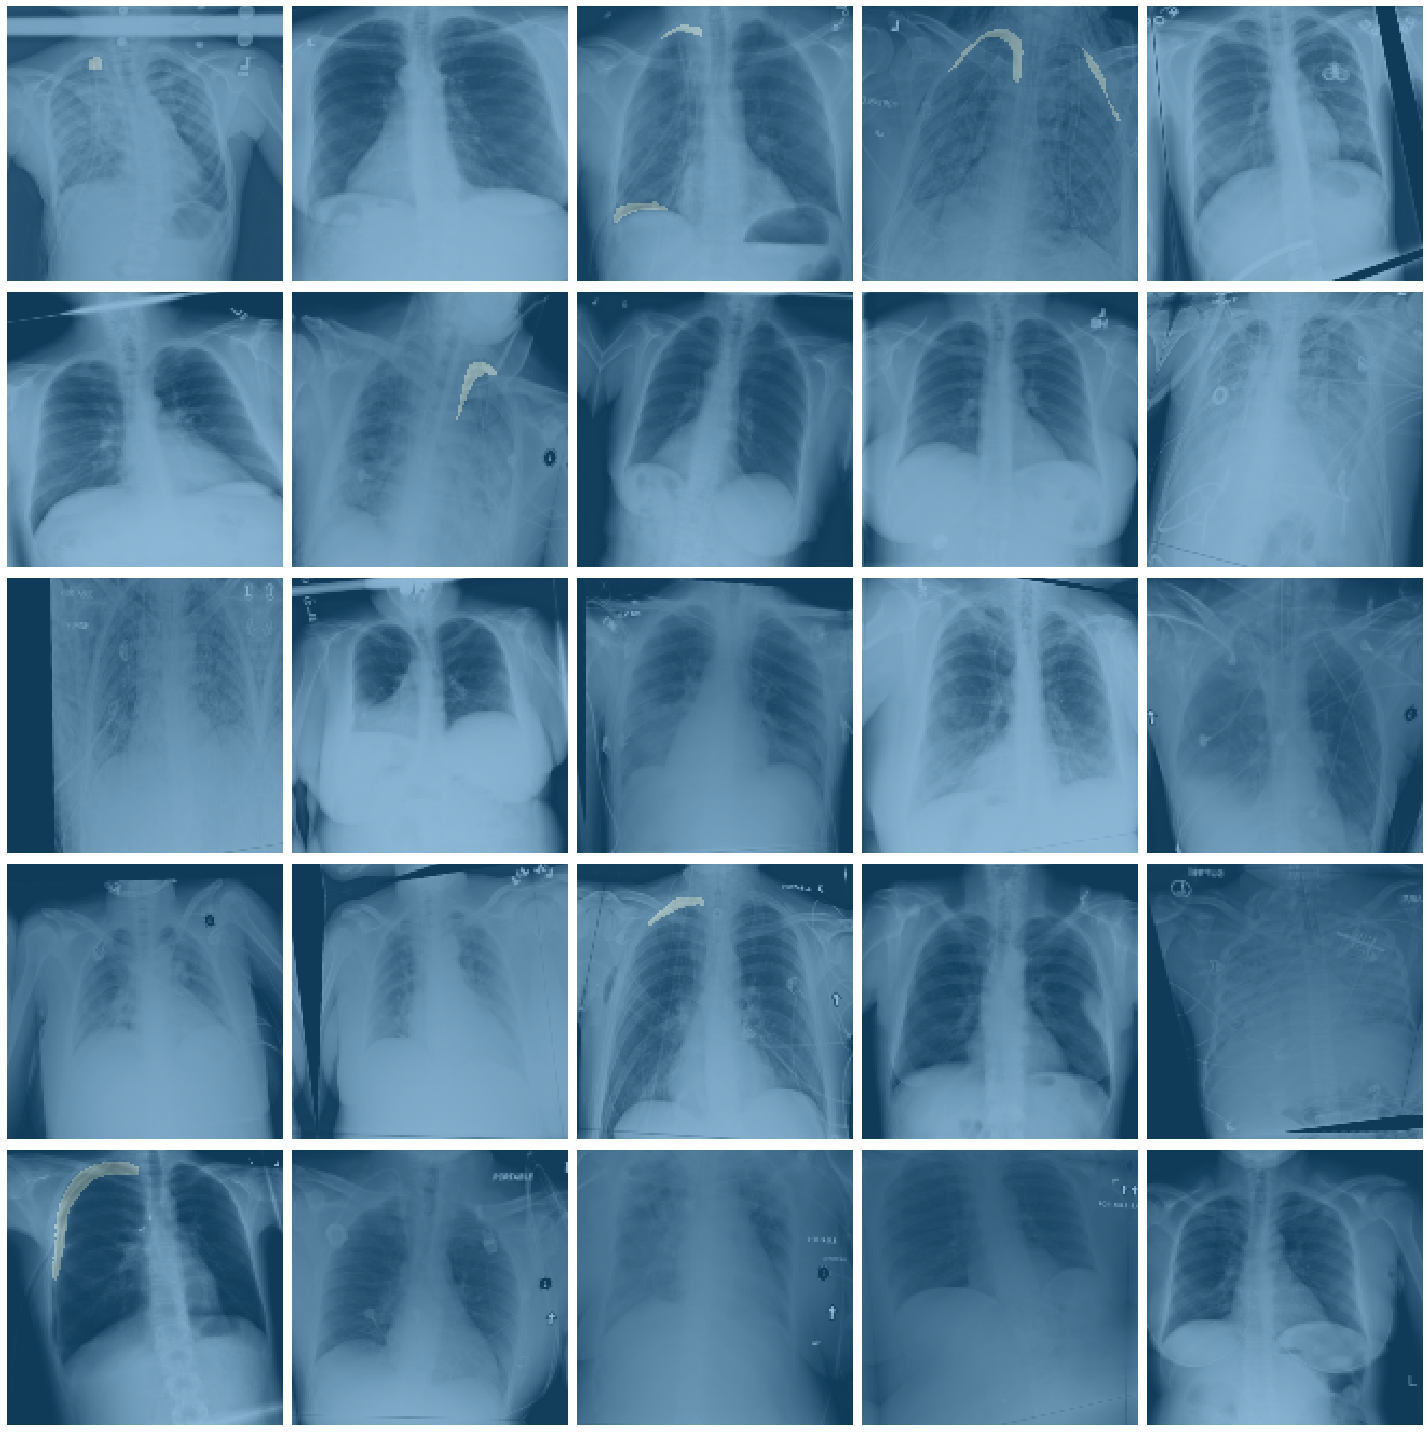

In [3]:
# data

# Setting div=True in open_mask
class SegmentationLabelList(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegmentationItemList(SegmentationItemList):
    _label_cls = SegmentationLabelList
    
# Setting transformations on masks to False on test set
def transform(self, tfms:Optional[Tuple[TfmList,TfmList]]=(None,None), **kwargs):
    if not tfms: tfms=(None,None)
    assert is_listy(tfms) and len(tfms) == 2
    self.train.transform(tfms[0], **kwargs)
    self.valid.transform(tfms[1], **kwargs)
    kwargs['tfm_y'] = False # Test data has no labels
    if self.test: self.test.transform(tfms[1], **kwargs)
    return self
fastai.data_block.ItemLists.transform = transform

# Create databunch
data = (SegmentationItemList.from_csv(path=path, csv_name='unet_siim_5fold_256/all_0.csv')
        .split_by_fname_file('unet_siim_5fold_256/val_0.csv', path=path)
        .label_from_func(lambda x : str(x).replace('train_png', 'mask_png'), classes=[0, 1])
        .add_test((path/'test_png').ls(), label=None)
        .transform(get_transforms(), size=128, tfm_y=True)
        .databunch(path=Path('.'), bs=64)
        .normalize(imagenet_stats))

data.show_batch()


In [4]:
# focal loss

import torch
import torch.nn as nn
import torch.nn.functional as F

from fastai.layers import FlattenedLoss

def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.detach()].to(labels.device)

class FocalLoss(nn.Module):
    def __init__(self, num_classes, alpha=0.25, gamma=2.):
        super().__init__()
        self.num_classes = num_classes
        self.alpha = alpha
        self.gamma = gamma
        
    # pred is flatten one hot array, while tgt is just a mask
    def forward(self, pred, tgt):
        t = one_hot_embedding(tgt, self.num_classes)
        t = t.transpose(-1, -1).contiguous().view(-1).float()
        
        x = F.softmax(pred.view(-1, 2), dim=-1).view(-1).float()
        
        pt = x * t + (1 - x) * (1 - t)
        at = self.alpha * t + (1 - self.alpha) * (1 - t)
        w = at * (1 - pt).pow(self.gamma)
        
        l = -w * torch.log(pt)

        return l.mean(dim=-1)
            
def FocalFlat(*args, axis:int=-1, floatify:bool=False, **kwargs):
    return FlattenedLoss(FocalLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)


In [5]:
# Create U-Net with a pretrained resnet34 as encoder
learn = unet_learner(data, models.resnet34, loss_func=FocalFlat(2), metrics=[dice])


In [6]:
# Fit one cycle of 6 epochs with max lr of 1e-3
learn.fit_one_cycle(6, slice(1e-4))


epoch,train_loss,valid_loss,dice,time


KeyboardInterrupt: 

In [ ]:
# Unfreeze the encoder (resnet34)
learn.unfreeze()

from fastai.callbacks import *

# Fit one cycle of 12 epochs
lr = 1e-3
learn.fit_one_cycle(12, slice(lr/30, lr), callbacks=[SaveModelCallback(learn, every='epoch', monitor='dice')])


In [ ]:
# TODO : export and load model

learn.freeze()
learn.export()
# learn.export(destroy=True) # or learn.export() + learn.destroy()


## Eval

In [6]:
# load learner

learn = load_learner('./', 'export.pkl')


In [8]:
# Predictions for validation set

soft_masks_ = []
target_masks_ = []

with tqdm(total=len(data.valid_ds), file=sys.stdout) as pbar:
    for img, ys in data.valid_ds:
        pred = learn.predict(img)
        
        soft_masks_.append(pred[2][1].squeeze())
        target_masks_.append(ys.data.squeeze())
        
        pbar.update(1)


100%|██████████| 2136/2136 [01:06<00:00, 32.25it/s]


In [9]:
soft_masks = torch.stack(soft_masks_, dim=0)
target_masks = torch.stack(target_masks_, dim=0)

print('{}, {}'.format(soft_masks.shape, target_masks.shape))


torch.Size([2136, 128, 128]), torch.Size([2136, 128, 128])


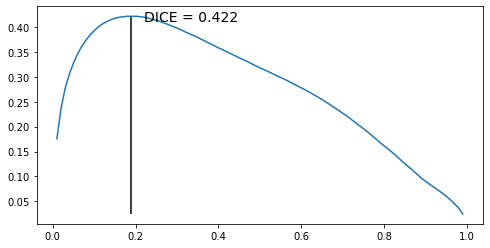

In [10]:
def dice_overall(preds, targs):
    n = preds.shape[0]
    preds = preds.view(-1)
    targs = targs.view(-1)
    intersect = (preds * targs).sum(-1).float()
    union = (preds+targs).sum(-1).float()
    return (2. * intersect / union)

# Find optimal threshold
dices = []

thrs = np.arange(0.01, 1, 0.01)
for i in progress_bar(thrs):
    preds_m = (soft_masks>i).long()
    dices.append(dice_overall(preds_m, target_masks).mean())
dices = np.array(dices)

best_dice = dices.max()
best_thr = thrs[dices.argmax()]

plt.figure(figsize=(8,4))

plt.plot(thrs, dices)
plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max())
plt.text(best_thr+0.03, best_dice-0.01, f'DICE = {best_dice:.3f}', fontsize=14);

plt.show()


In [46]:
# Plot some samples
rows = 10
plot_idx = ys.sum((1,2)).sort(descending=True).indices[:rows]

for idx in plot_idx:
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
    
    ax0.imshow(data.valid_ds[idx][0].data.numpy().transpose(1,2,0))
    ax1.imshow(ys[idx], vmin=0, vmax=1)
    ax2.imshow(preds[idx], vmin=0, vmax=1)

    ax1.set_title('Targets')
    ax2.set_title('Predictions')
    

AttributeError: 'ImageSegment' object has no attribute 'sum'

## Test

In [47]:
# load learner

learn = load_learner('./', 'export.pkl')


In [11]:
# Predictions for test set

soft_masks_ = []

with tqdm(total=len(data.test_ds), file=sys.stdout) as pbar:
    for img in data.test_ds:
        pred = learn.predict(img[0])
        soft_masks_.append(pred[2][1])
        
        pbar.update(1)
    

100%|██████████| 1377/1377 [00:32<00:00, 41.85it/s]


In [12]:
# convert to hard masks

soft_masks = torch.stack(soft_masks_, dim=0).squeeze()
hard_masks = (soft_masks>best_thr).to(dtype=torch.uint8).numpy()


In [13]:
# instance segmentation

mask_list = []

for p in progress_bar(hard_masks):
    # find out contours
    contours, hierarchy = cv2.findContours(p, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    # create masks for contours
    masks = []

    for i in range(len(contours)):
        mask = np.zeros((256, 256))

        # draw a single mask from its contour
        cv2.drawContours(mask, contours, i, 1, -1)
        masks.append(mask)
        
    mask_list.append(masks)
    

In [14]:
# noise removal

noise_threshold = 30

clean_mask_list = []

for masks in progress_bar(mask_list):
    clean_masks = []
    
    for mask in masks:
        if mask.sum() >= noise_threshold:
            clean_masks.append(mask)
    
    clean_mask_list.append(clean_masks)
    

In [18]:
# Generate rle encodings (images are first converted to the original size)
rle_list = []

for p in progress_bar(clean_mask_list):
    rles = []
    
    for mask in p:
        im = PIL.Image.fromarray((mask.T).astype(np.uint8)).resize((1024,1024))
        im = np.asarray(im)
        
        rle = mask2rle(im, 1024, 1024)
        rles.append(rle)
        
    rle_list.append(rles)
    

In [19]:
ids = [o.stem for o in data.test_ds.items]
sub_list = []

for uid, rles in zip(ids, rle_list):
    if len(rles) > 0:
        for rle in rles:
            sub_list.append([uid, rle])
    else:
        sub_list.append([uid, ' -1'])

sub_df = pd.DataFrame(sub_list, columns=['ImageId', 'EncodedPixels'])
sub_df.head(5)


,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6106.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.6588.151787519...,-1
2,1.2.276.0.7230010.3.1.4.8323329.6014.151787519...,-1
3,1.2.276.0.7230010.3.1.4.8323329.6813.151787520...,-1
4,1.2.276.0.7230010.3.1.4.8323329.699.1517875164...,-1


In [20]:
sub_df.to_csv('unet_sub_{:.5f}.csv'.format(best_thr), index=False)
